<a href="https://colab.research.google.com/github/ziishanahmad/ai-llava-fine-tuned-with-scrapped-images./blob/main/ai_llava_fine_tuned_with_scrapped_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import requests
import json
import torch
from PIL import Image
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from collections import deque
from datasets import Dataset
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

# Determine if GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to download images and create JSON dataset
def download_images_and_create_json(url, output_dir, json_path, max_depth=2, max_images=10):
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    data = []  # Initialize list to hold image data
    visited_urls = set()  # Track visited URLs to avoid loops
    queue = deque([(url, 0)])  # Initialize queue with the starting URL and depth
    image_count = 0  # Counter for the number of images downloaded

    # While there are URLs to process and the max number of images has not been reached
    while queue and image_count < max_images:
        current_url, depth = queue.popleft()
        if depth > max_depth or current_url in visited_urls:
            continue
        visited_urls.add(current_url)

        try:
            response = requests.get(current_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            image_tags = soup.find_all('img')

            # Process each image tag found
            for img in image_tags:
                img_url = img.get('src')
                alt_tag = img.get('alt', '')

                if img_url:
                    img_url = urljoin(current_url, img_url)  # Resolve relative URLs
                    img_name = img_url.split('/')[-1]
                    img_ext = img_name.split('.')[-1]

                    # Skip non-image files
                    if img_ext not in ['jpg', 'png', 'jpeg']:
                        continue

                    img_response = requests.get(img_url, stream=True)
                    img_response.raw.decode_content = True

                    img_path = os.path.join(output_dir, img_name)
                    with open(img_path, 'wb') as f:
                        f.write(img_response.content)

                    # Append image data to list
                    data.append({
                        "id": f"image_{image_count}",
                        "image": img_path,
                        "conversations": [
                            {"from": "human", "value": "What is shown in the image?"},
                            {"from": "gpt", "value": alt_tag}
                        ]
                    })
                    image_count += 1
                    if image_count >= max_images:
                        break

                    print(f"Downloaded: {img_path}, Alt Tag: {alt_tag}")

        except Exception as e:
            print(f"Error fetching {current_url}: {e}")

        if depth < max_depth:
            for link in soup.find_all('a', href=True):
                next_url = urljoin(current_url, link['href'])
                if urlparse(next_url).netloc == urlparse(url).netloc:
                    queue.append((next_url, depth + 1))

    # Write the collected image data to a JSON file
    with open(json_path, 'w') as f:
        json.dump(data, f, indent=4)

# Example usage
website_url = 'https://www.apple.com/iphone/'  # The website to scrape
output_dir = '/content/applescrapper2'  # Directory to save images
json_path = '/content/dataset.json'  # Path to save the JSON dataset
download_images_and_create_json(website_url, output_dir, json_path)

# Function to load the dataset from the JSON file
def load_json_dataset(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    images = [item["image"] for item in data]
    captions = [item["conversations"][1]["value"] for item in data]
    return Dataset.from_dict({'image_path': images, 'caption': captions})

# Load the datasets from the JSON file
train_dataset = load_json_dataset(json_path)
val_dataset = load_json_dataset(json_path)

# Load the pre-trained model, feature extractor, and tokenizer
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Preprocess function to prepare the data for training
def preprocess_function(examples):
    images = [Image.open(image).convert("RGB") for image in examples["image_path"]]
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    captions = tokenizer(examples["caption"], padding="max_length", truncation=True, return_tensors="pt")
    return {"pixel_values": pixel_values, "labels": captions.input_ids}

# Apply the preprocess function to the datasets
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["image_path", "caption"])
val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=["image_path", "caption"])

# Define the training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3
)

# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

# Save the fine-tuned model, tokenizer, and feature extractor
model.save_pretrained("/content/fine_tuned_model")
tokenizer.save_pretrained("/content/fine_tuned_tokenizer")
feature_extractor.save_pretrained("/content/fine_tuned_feature_extractor")


Downloaded: /content/applescrapper2/startframe__d10cha77b2eu_xlarge.jpg, Alt Tag: 
Downloaded: /content/applescrapper2/suerte_startframe__erik0fsmh90m_xlarge.jpg, Alt Tag: 
Downloaded: /content/applescrapper2/suerte_startframe__erik0fsmh90m_xlarge.jpg, Alt Tag: 
Downloaded: /content/applescrapper2/cinematic_mode__eqivqhqqnj42_large.png, Alt Tag: Image showing Cinematic mode with the characters from the film.
Downloaded: /content/applescrapper2/cinematic_mode__eqivqhqqnj42_large.png, Alt Tag: Image showing Cinematic mode with the characters from the film.
Downloaded: /content/applescrapper2/zoom_mode__e4ie3pa3mt2e_large.png, Alt Tag: Image showing 5x optical zoom on iPhone 15 Pro Max with a character from the film.
Downloaded: /content/applescrapper2/zoom_mode__e4ie3pa3mt2e_large.png, Alt Tag: Image showing 5x optical zoom on iPhone 15 Pro Max with a character from the film.
Downloaded: /content/applescrapper2/low_light_mode__f651x14macuq_large.png, Alt Tag: Image showing a scene shot i

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.064620
2,No log,0.056917
3,No log,0.053913


['/content/fine_tuned_feature_extractor/preprocessor_config.json']

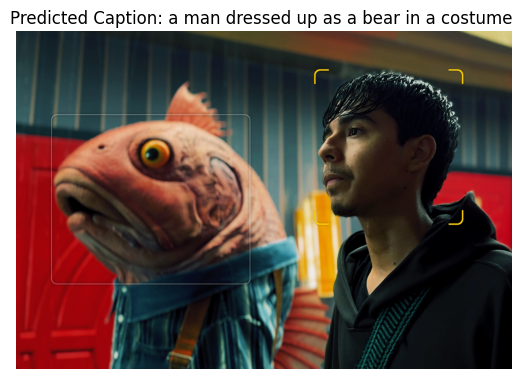

In [17]:
import torch
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image
import matplotlib.pyplot as plt

# Define device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model, tokenizer, and feature extractor
model = VisionEncoderDecoderModel.from_pretrained("/content/fine_tuned_model").to(device)
feature_extractor = ViTImageProcessor.from_pretrained("/content/fine_tuned_feature_extractor")
tokenizer = AutoTokenizer.from_pretrained("/content/fine_tuned_tokenizer")

# Function to predict the caption of an image
def predict_caption(image_path, model):
    # Open the image
    image = Image.open(image_path).convert("RGB")

    # Preprocess the image
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate caption
    output_ids = model.generate(pixel_values, max_length=16, num_beams=4, return_dict_in_generate=True).sequences
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return image, caption

# Provide the path to a new image (use one of the previously downloaded images)
new_image_path = '/content/applescrapper2/cinematic_mode__eqivqhqqnj42_large.png'

# Predict and display the caption
image, caption = predict_caption(new_image_path, model)
plt.imshow(image)
plt.title(f"Predicted Caption: {caption}")
plt.axis("off")
plt.show()
